#  Чётенькое такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Библиотеки

Импортируем библиотеки.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

И все используемое далее.

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

Отключаем лишние предупреждения.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Функции

#### column_values

In [ ]:
def column_values(data_frame):
    '''
    Функция для визуального поиска артефактов и выбросов в значениях DataFrame
    '''
    for column in data_frame.columns:
        print('\nЗначения столбца', column,':')
        print(data_frame[column].sort_values().unique())

#### cv_sample

In [ ]:
def cv_sample(regressor, data, target_column, n_splits, max_train_size):
    '''
    Создание CV выборки для временных рядов через TimeSeriesSplit
    '''
    tss = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tss.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop(target_column, axis=1)
        train_target = train[target_column]
        test_features = test.drop(target_column, axis=1)
        test_target = test[target_column]
        regressor.fit(train_features, train_target)
        RMSE += mean_squared_error(test_target, regressor.predict(test_features)) ** 0.5
    return RMSE / n_splits

#### df_info

In [ ]:
def df_info(data_frame):
    '''
    Функция выводящая первичную информацию о DataFrame
    '''
    print('\nРазмер таблицы: {} '.format(data_frame.shape))
    print('\nИнфо:')
    print(data_frame.info())                                            # сколько значений и в каком формате
    print('\nПропусков:')
    print(data_frame.isna().mean().sort_values(ascending=False) * 100)  # подсчёт пропусков в процентах
    print('\nОписание:')
    display(data_frame.describe())                                      # вдруг чего "на глазок" проявится 
    print('\nДубликатов =', data_frame.duplicated().sum())              # проверим дубликаты

#### make_features

In [ ]:
def make_features(data_frame, column, max_lag, rolling_mean_size):
    '''
    Cоздание признаков для обучения модели
    '''
    data_frame['day'] = data_frame.index.day
    data_frame['dayofweek'] = data_frame.index.dayofweek
    data_frame['month'] = data_frame.index.month
    for lag in range(1, max_lag + 1):
        data_frame['lag_{}'.format(lag)] = data_frame[column].shift(lag)
    data_frame['rolling_mean'] = data_frame[column].shift().rolling(rolling_mean_size).mean()

### Таблица

Читаем файл с данными и сохраняем в df.

In [ ]:
df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

Смотрим табличку.

In [ ]:
display(df.columns)
print()
display(df.head())

Index(['num_orders'], dtype='object')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим заполненость таблицы.

In [ ]:
df_info(df)


Размер таблицы: (26496, 1) 

Инфо:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

Пропусков:
num_orders    0.0
dtype: float64

describe:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



Дубликатов = 26415


### Вывод

    - Вроде бы все "ровно", но 26415 дубликатов из 26496 значений...
      Интересно.

## Анализ

Отлавливаем артефакты в данных.

In [ ]:
column_values(df)


Значения столбца num_orders :
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  60  61  62  64  65  66  67  68  71  76  78  80  81
  82  87  90  91  94  95  98  99 119]


За какой период смотрим?

In [ ]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Как выглядят наши данные?

Text(0.5, 1.0, 'Распределение по неделям')

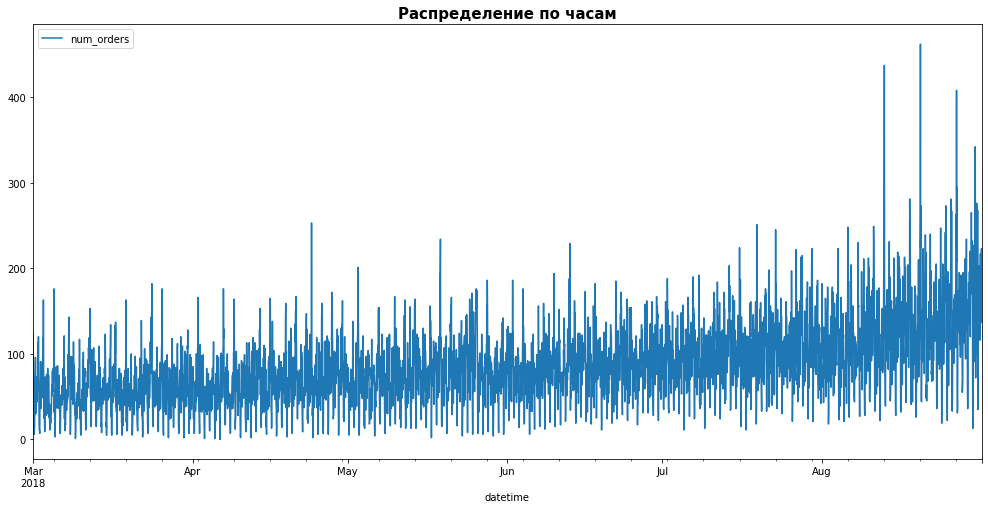

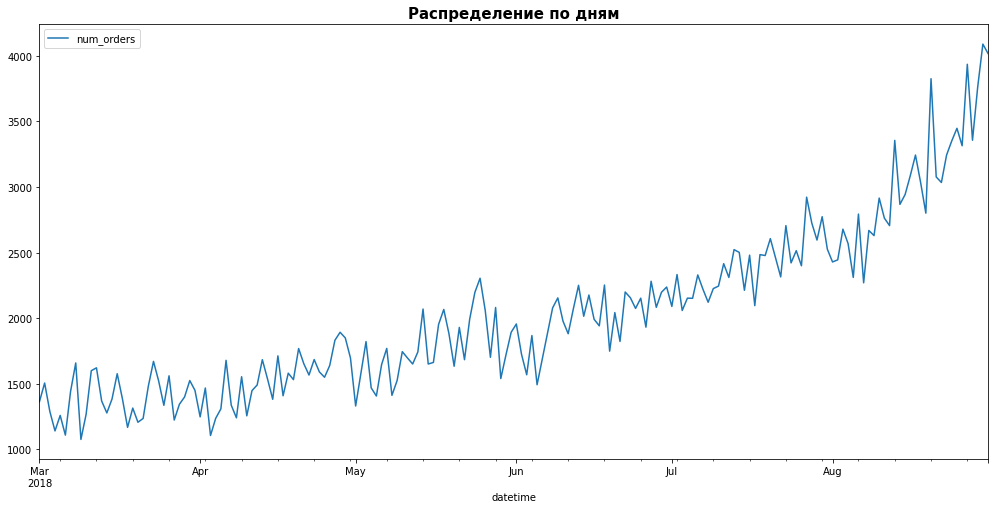

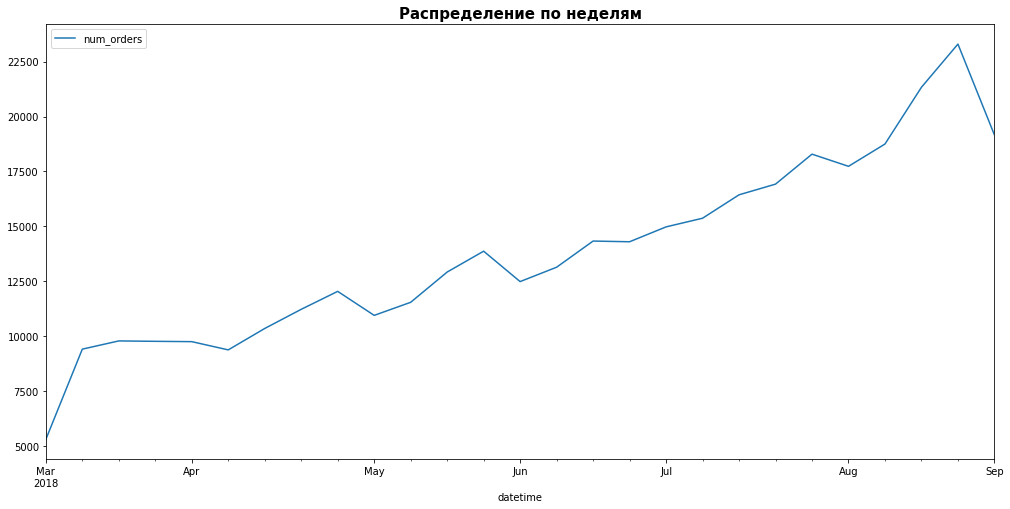

In [ ]:
df_h = df.resample('1H').sum()
figsize = (17,8)
df_h.plot(figsize=figsize)
plt.title('Распределение по часам',
          fontsize = 15,
          fontweight = 'bold')

df_d = df.resample('1D').sum()
figsize = (17,8)
df_d.plot(figsize=figsize)
plt.title('Распределение по дням',
          fontsize = 15,
          fontweight = 'bold')

df_w = df.resample('1W').sum()
figsize = (17,8)
df_w.plot(figsize=figsize)
plt.title('Распределение по неделям',
          fontsize = 15,
          fontweight = 'bold')


Сделаем декомпозицию, посмотрим тренды и сезонность заказа такси.

<AxesSubplot:title={'center':'Тренды и сезонность'}, xlabel='datetime'>

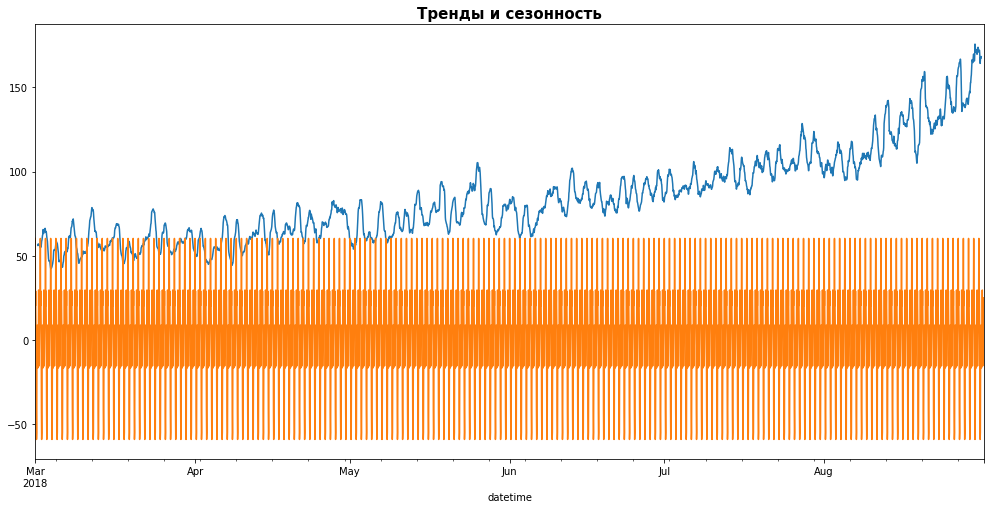

In [ ]:
plt.title('Тренды и сезонность',
          fontsize = 15,
          fontweight = 'bold')
decomposed_df = seasonal_decompose(df_h)
decomposed_df.trend.plot(figsize=figsize)
decomposed_df.seasonal.plot(figsize=figsize)

Укрупним до месяца.

<AxesSubplot:title={'center':'Тренды и сезонность за 3 месяца'}, xlabel='datetime'>

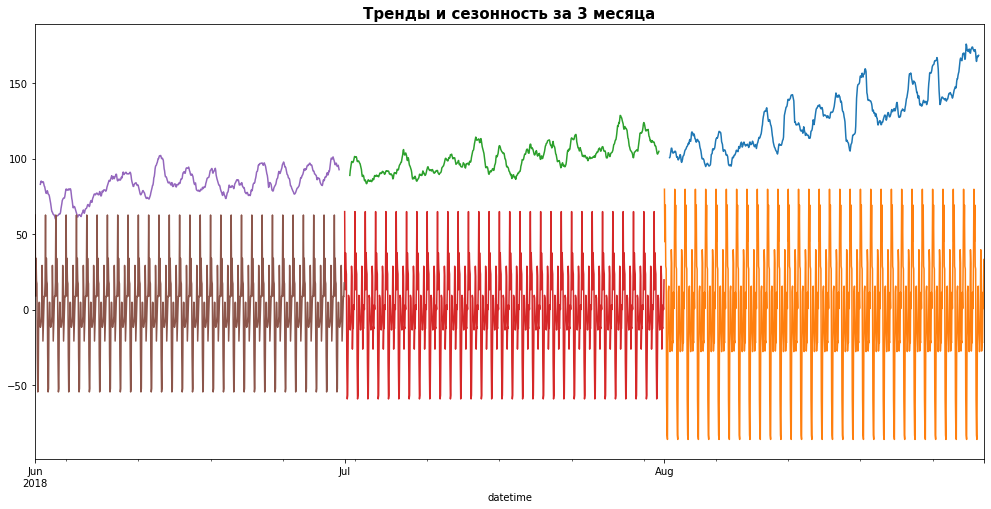

In [ ]:
plt.title('Тренды и сезонность за 3 месяца',
          fontsize = 15,
          fontweight = 'bold')
decomposed_df_h = seasonal_decompose(df_h['2018-08-1':'2018-08-31'])
decomposed_df_h.trend.plot(figsize=figsize)
decomposed_df_h.seasonal.plot(figsize=figsize)

decomposed_df_h = seasonal_decompose(df_h['2018-07-1':'2018-07-31'])
decomposed_df_h.trend.plot(figsize=figsize)
decomposed_df_h.seasonal.plot(figsize=figsize)

decomposed_df_h = seasonal_decompose(df_h['2018-06-1':'2018-06-30'])
decomposed_df_h.trend.plot(figsize=figsize)
decomposed_df_h.seasonal.plot(figsize=figsize)

Укрупним до недель.

<AxesSubplot:title={'center':'Тренды и сезонность за 3 недели'}, xlabel='datetime'>

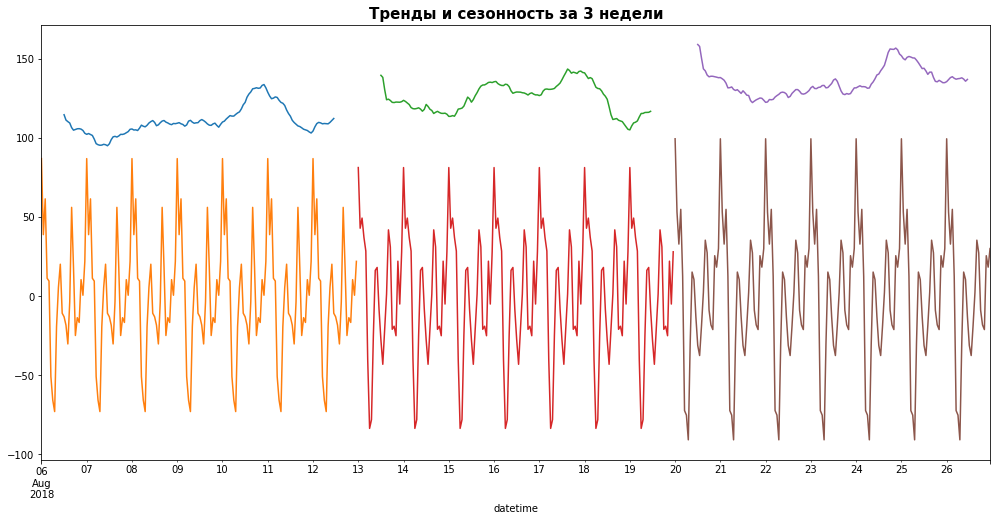

In [ ]:
plt.title('Тренды и сезонность за 3 недели',
          fontsize = 15,
          fontweight = 'bold')
decomposed_df_h = seasonal_decompose(df_h['2018-08-6':'2018-08-12'])
decomposed_df_h.trend.plot(figsize=figsize)
decomposed_df_h.seasonal.plot(figsize=figsize)

decomposed_df_h = seasonal_decompose(df_h['2018-08-13':'2018-08-19'])
decomposed_df_h.trend.plot(figsize=figsize)
decomposed_df_h.seasonal.plot(figsize=figsize)

decomposed_df_h = seasonal_decompose(df_h['2018-08-20':'2018-08-26'])
decomposed_df_h.trend.plot(figsize=figsize)
decomposed_df_h.seasonal.plot(figsize=figsize)

Укрупним до часов.

<AxesSubplot:title={'center':'Тренды и сезонность за 3 дня'}, xlabel='datetime'>

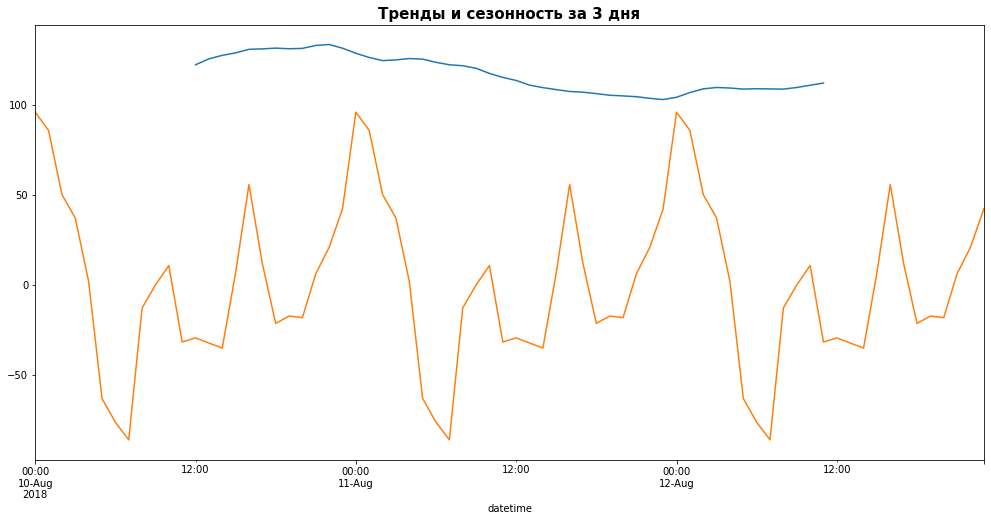

In [ ]:
plt.title('Тренды и сезонность за 3 дня',
          fontsize = 15,
          fontweight = 'bold')
decomposed_df_h = seasonal_decompose(df_h['2018-08-10':'2018-08-12'])
decomposed_df_h.trend.plot(figsize=figsize)
decomposed_df_h.seasonal.plot(figsize=figsize)

### Вывод

    - В общем количество заказов растет.
    - Максимум заказов приходится на
        - суббота
        - ночь
    - Минимум заказов приходится на
        - вторник и среда
        - утро

## Обучение

### Подготовка данных

Посмотрим, какие признаки нам понадобится:

    - Видна ежедневная сезонность - понадобится признак day.
    - Есть закономерности по дням недели - добавим признак dayofweek.
    - Помесячные данные отличаются, но довольно похожи - добавим признак month.

In [ ]:
max_lag = 24
rolling_mean_size = 5

Делаем тестовую выборку размером 10% от исходных данных.

In [ ]:
make_features(df_h, 'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(df_h,
                               shuffle=False,
                               test_size=0.1,
                               random_state=1980)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))

Размер обучающей выборки: 3950 объектов, 28 признаков
Размер тестовой выборки: 442 объектов, 28 признаков


Посмотрим корреляцию признаков.

<AxesSubplot:>

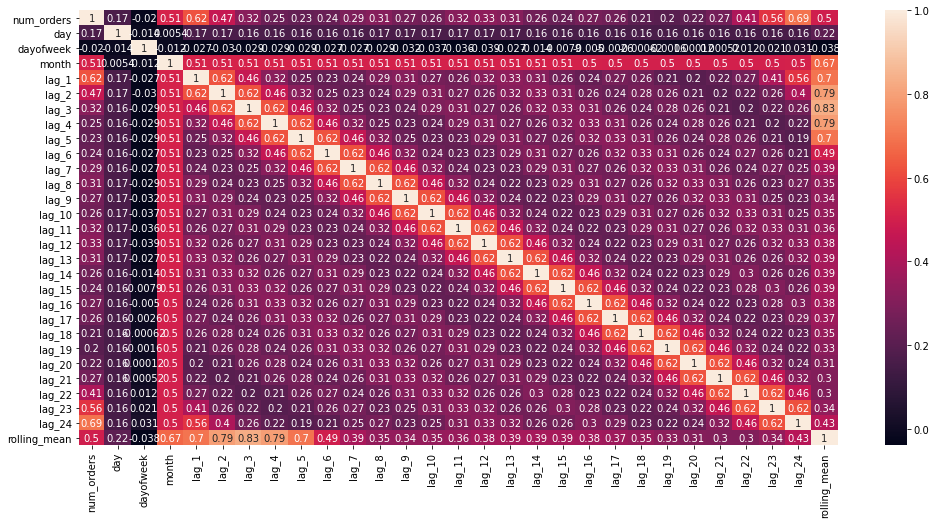

In [ ]:
figure = plt.figure(figsize=figsize)
sns.heatmap(df_h.corr(method='pearson'),
            annot = True)

### Общие переменные

In [ ]:
data  = train
target_column = 'num_orders'
n_splits = 3
max_train_size = (train.shape[0] * 4 //5)

### LinearRegression

In [ ]:
%%time
regressor_lr = LinearRegression()
hyperparams = {'normalize':[True, False]}
tss = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
grid_lr = GridSearchCV(regressor_lr,
                       hyperparams,
                       scoring='neg_root_mean_squared_error',
                       cv=tss ,
                       n_jobs = -1)
grid_lr.fit(features_train,
            target_train)
print('Лучший набор параметров:\n')
best_params_lr = grid_lr.best_params_
print(best_params_lr, '\n')  

Лучший набор параметров:

{'normalize': False} 

CPU times: user 520 ms, sys: 652 ms, total: 1.17 s
Wall time: 1.17 s


In [ ]:
rmse_lr = cv_sample(regressor = regressor_lr,
                    data = data, 
                    target_column = target_column, 
                    n_splits = n_splits, 
                    max_train_size = max_train_size)
print('RMSE для LinearRegression =', rmse_lr, '\n')     

RMSE для LinearRegression = 27.53098873025861 



### DecisionTreeRegressor

In [ ]:
%%time
regressor_dtr = DecisionTreeRegressor()
#max_depth = [depth for depth in range(1, 50)]
max_depth = [depth for depth in range(3, 5)]
hyperparams = [{'criterion':['mse', 'squared_error', 'friedman_mse'], 
                'max_depth':max_depth, 
                'random_state':[1980]}]
grid_dtr = GridSearchCV(regressor_dtr,
                        hyperparams,
                        scoring='neg_root_mean_squared_error')
grid_dtr.fit(features_train,
             target_train)
print('Лучший набор параметров:\n')
best_params_dtr = grid_dtr.best_params_
print(best_params_dtr, '\n')

Лучший набор параметров:

{'criterion': 'mse', 'max_depth': 4, 'random_state': 1980} 

CPU times: user 479 ms, sys: 43.3 ms, total: 522 ms
Wall time: 529 ms


In [ ]:
%%time
regressor_dtr.set_params(**best_params_dtr)
rmse_dtr = cv_sample(regressor = regressor_dtr,
                     data = data, 
                     target_column = target_column, 
                     n_splits = n_splits, 
                     max_train_size = max_train_size)
print('RMSE для DecisionTreeRegressor =', rmse_dtr, '\n')

RMSE для DecisionTreeRegressor = 31.50623451409257 

CPU times: user 49.9 ms, sys: 26 µs, total: 49.9 ms
Wall time: 48.2 ms


### CatBoostRegressor

In [ ]:
%%time
regressor_cbr = CatBoostRegressor() 
hyperparams = [{#'learning_rate':[x/100 for x in range(1, 200)],
                'learning_rate':[x/100 for x in range(3, 5)],
                'verbose':[False],
                'random_state':[1980]}]
grid_cbr = GridSearchCV(regressor_cbr,
                        hyperparams,
                        scoring='neg_root_mean_squared_error')
grid_cbr.fit(features_train,
             target_train)
print('Лучший набор параметров:\n')
best_params_cbr = grid_cbr.best_params_
print(best_params_cbr, '\n')

Лучший набор параметров:

{'learning_rate': 0.04, 'random_state': 1980, 'verbose': False} 

CPU times: user 56.7 s, sys: 1.45 s, total: 58.1 s
Wall time: 1min 7s


In [ ]:
%%time
regressor_cbr.set_params(**best_params_cbr)
rmse_cbr = cv_sample(regressor = regressor_cbr,
                     data = data, 
                     target_column = target_column, 
                     n_splits = n_splits, 
                     max_train_size = max_train_size)
print('RMSE для CatBoostRegressor =', rmse_cbr, '\n')

RMSE для CatBoostRegressor = 26.240442152104084 

CPU times: user 11.9 s, sys: 444 ms, total: 12.4 s
Wall time: 14.7 s


### LGBMRegressor

In [ ]:
%%time
regressor_lgbmr = LGBMRegressor() 
hyperparams = [{#'learning_rate':[x/100 for x in range(1, 200)],
                'learning_rate':[x/100 for x in range(4, 6)],
                #'n_estimators':[50, 150, 300],
                'n_estimators':[300],
                #'num_leaves':[6, 12, 24],
                'num_leaves':[12],
                'boosting_type':['gbdt'],
                'random_state':[1980]}]
grid_lgbmr = GridSearchCV(regressor_lgbmr,
                          hyperparams,
                          scoring='neg_root_mean_squared_error')
grid_lgbmr.fit(features_train,
               target_train)
print('Лучший набор параметров:\n')
best_params_lgbmr = grid_lgbmr.best_params_
print(best_params_lgbmr, '\n')

Лучший набор параметров:

{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'n_estimators': 300, 'num_leaves': 12, 'random_state': 1980} 

CPU times: user 35.4 s, sys: 187 ms, total: 35.6 s
Wall time: 35.8 s


In [ ]:
%%time
regressor_lgbmr.set_params(**best_params_lgbmr)
rmse_lgbmr = cv_sample(regressor = regressor_lgbmr,
                       data = data, 
                       target_column = target_column, 
                       n_splits = n_splits, 
                       max_train_size = max_train_size)
print('RMSE для LGBMRegressor =', rmse_lgbmr, '\n')

RMSE для LGBMRegressor = 26.911045220329708 

CPU times: user 3.91 s, sys: 18.8 ms, total: 3.93 s
Wall time: 4 s


## Тестирование

### LinearRegression

In [ ]:
%%time
regressor_lr.fit(features_train,
                 target_train)
predict_lr = regressor_lr.predict(features_test)
rmse_lr_test = mean_squared_error(target_test, predict_lr) ** 0.5
print('RMSE для LinearRegression =', rmse_lr_test, '\n')

Посмотрим предсказания с реальными данными.

RMSE для LinearRegression = 45.52933708020937 

CPU times: user 95 ms, sys: 136 ms, total: 231 ms
Wall time: 297 ms


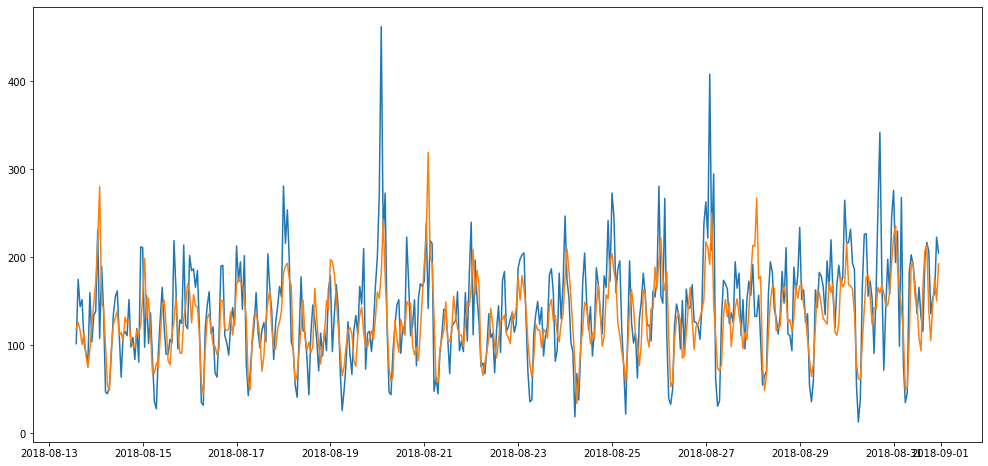

In [ ]:
plt.figure(figsize = figsize)
plt.plot(target_test.index,
         target_test,
         target_test.index,
         predict_lr)

### DecisionTreeRegressor

In [ ]:
%%time
regressor_dtr.fit(features_train,
                  target_train)
predict_dtr = regressor_dtr.predict(features_test)
rmse_dtr_test = mean_squared_error(target_test, predict_dtr) ** 0.5
print('RMSE для DecisionTreeRegressor =', rmse_dtr_test, '\n')

Посмотрим предсказания с реальными данными.

RMSE для DecisionTreeRegressor = 54.224766629322644 

CPU times: user 44.9 ms, sys: 4.03 ms, total: 48.9 ms
Wall time: 55.7 ms


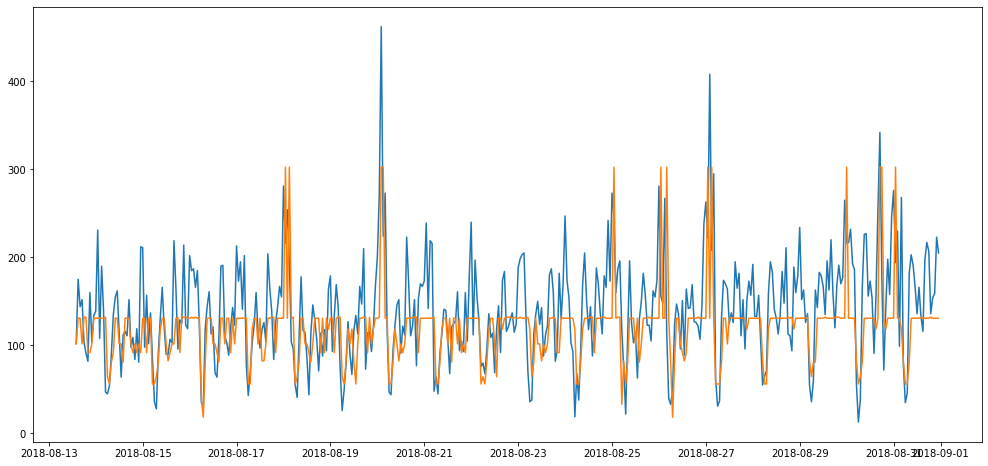

In [ ]:
plt.figure(figsize=figsize)
plt.plot(target_test.index,
         target_test,
         target_test.index,
         predict_dtr)

### CatBoostRegressor

In [ ]:
%%time
regressor_cbr.fit(features_train,
                  target_train)
predict_cbr = regressor_cbr.predict(features_test)
rmse_cbr_test = mean_squared_error(target_test, predict_cbr) ** 0.5
print('RMSE для CatBoostRegressor =', rmse_cbr_test, '\n')

Посмотрим предсказания с реальными данными.

RMSE для CatBoostRegressor = 40.41712327874132 

CPU times: user 5.59 s, sys: 109 ms, total: 5.69 s
Wall time: 6.39 s


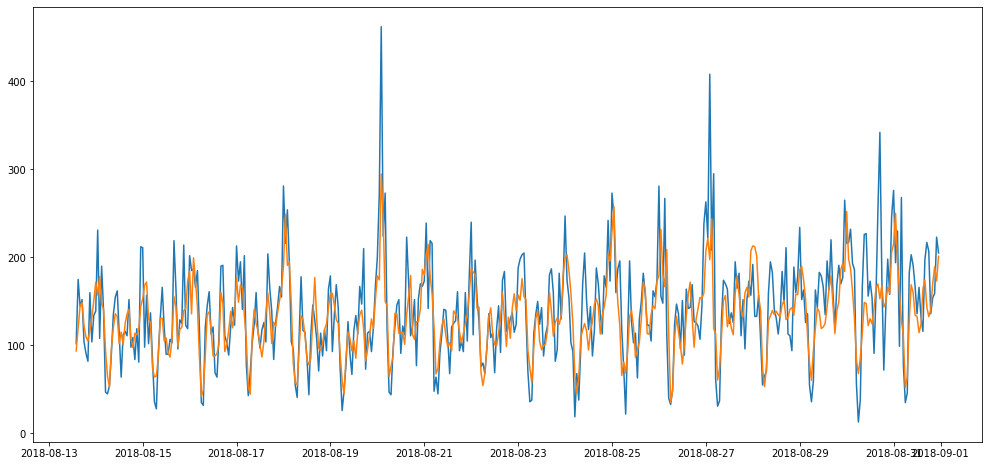

In [ ]:
plt.figure(figsize=figsize)
plt.plot(target_test.index,
         target_test,
         target_test.index,
         predict_cbr)

### LGBMRegressor

In [ ]:
%%time
regressor_lgbmr.fit(features_train,
                    target_train)
predict_lgbmr = regressor_lgbmr.predict(features_test)
rmse_lgbmr_test = mean_squared_error(target_test, predict_lgbmr) ** 0.5
print('RMSE для LGBMRegressor =', rmse_lgbmr_test, '\n')

Посмотрим предсказания с реальными данными.

RMSE для LGBMRegressor = 41.500149121968725 

CPU times: user 1.84 s, sys: 3.96 ms, total: 1.85 s
Wall time: 1.88 s


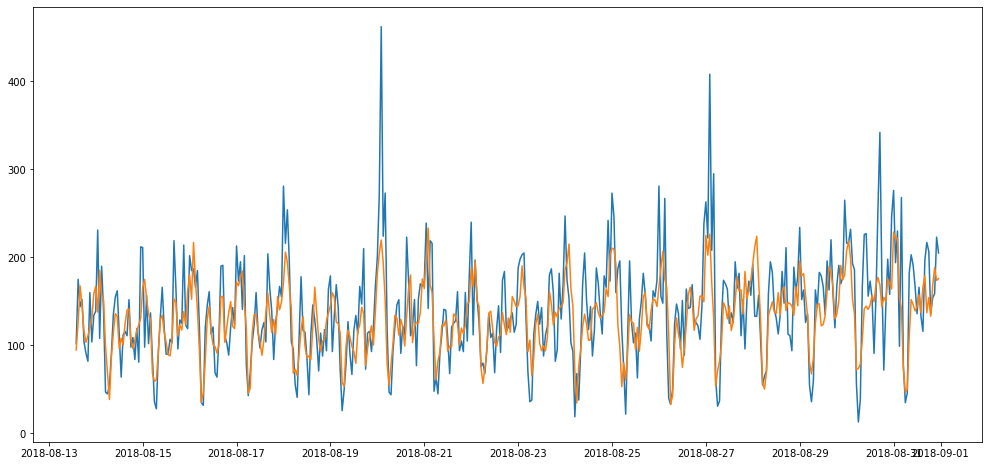

In [ ]:
plt.figure(figsize = figsize)
plt.plot(target_test.index,
         target_test,
         target_test.index,
         predict_lgbmr)

In [ ]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE на Train':[rmse_lr,
                         rmse_dtr,
                         rmse_cbr,
                         rmse_lgbmr],
        'RMSE на Test':[rmse_lr_test,
                        rmse_dtr_test,
                        rmse_cbr_test,
                        rmse_lgbmr_test]}
pivot = pd.DataFrame(data = data,
                     index=index)
pivot['Выполнение задачи'] = pivot['RMSE на Test'] < 48.0
pivot

,RMSE на Train,RMSE на Test,Выполнение задачи
LinearRegression,27.530989,45.529337,True
DecisionTreeRegressor,31.506235,54.224767,False
CatBoostRegressor,26.240442,40.417123,True
LGBMRegressor,26.911045,41.500149,True


### Вывод

В проекте были исследованы исторические данные о заказах такси в аэропортах. 

Были проанализированы 4 модели прогнозирования количество заказов такси на следующий час. Для трех из них удалось подобрать параметры, которые обеспечили требуемую точность предсказания в RMSE не больше 48.

Лучшей оказалась модель CatBoostRegressor с RMSE на тестовой выборке = 40.42.